In [14]:
%pylab inline
%load_ext autoreload
%autoreload 2

from pywsi.normalization import MacenkoNormalization
from pywsi.normalization import ReinhardNormalization

from pywsi.io import WSIReader
import numpy.linalg as LA
from skimage.filters import try_all_threshold

from sklearn.decomposition import NMF
from sklearn.decomposition import nmf
from sklearn.linear_model import Lasso

from sklearn.utils.testing import assert_array_almost_equal
from sklearn.utils.testing import assert_almost_equal
from numpy import linalg as LA
from skimage.color import rgb2gray
import spams

from skimage.feature import canny


def fractal_dimension(Z, threshold=0.9):

    # Only for 2d image
    assert(len(Z.shape) == 2)

    # From https://github.com/rougier/numpy-100 (#87)
    def boxcount(Z, k):
        S = np.add.reduceat(
            np.add.reduceat(Z, np.arange(0, Z.shape[0], k), axis=0),
                               np.arange(0, Z.shape[1], k), axis=1)

        # We count non-empty (0) and non-full boxes (k*k)
        return len(np.where((S > 0) & (S < k*k))[0])


    # Transform Z into a binary array
    Z = (Z < threshold)

    # Minimal dimension of image
    p = min(Z.shape)

    # Greatest power of 2 less than or equal to p
    n = 2**np.floor(np.log(p)/np.log(2))

    # Extract the exponent
    n = int(np.log(n)/np.log(2))

    # Build successive box sizes (from 2**n down to 2**1)
    sizes = 2**np.arange(n, 1, -1)

    # Actual box counting with decreasing size
    counts = []
    for size in sizes:
        counts.append(boxcount(Z, size))

    # Fit the successive log(sizes) with log (counts)
    coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
    return -coeffs[0]


Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/saket/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['normal']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
normal = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/normal/normal_004.tif'
tumor = '/Z/personal-folders/interns/saket/histopath_data/CAMELYON16/training/tumor/tumor_001.tif'

tumor_wsi = WSIReader(tumor, 40)
normal_wsi = WSIReader(normal, 40)

In [3]:
x0 = int(59792/2)#30000
y0 = int(233184/2)

tumor_rgb = tumor_wsi.get_patch_by_level(x0, y0, level=0, patch_size=1000)



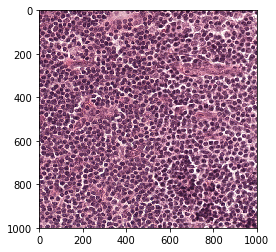

In [4]:
plt.imshow(tumor_rgb)


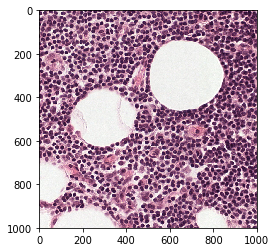

In [5]:
x0 = int(97256/2)
y0 = int(218624/2)

normal_rgb = normal_wsi.get_patch_by_level(x0, y0, level=0, patch_size=1000)

plt.imshow(normal_rgb)

In [6]:
normal_wsi.level_dimensions[0]

(96256, 218624)

# Macenko normalization

In [7]:
macenko_fit = MacenkoNormalization()
macenko_fit.fit(np.asarray(tumor_rgb).astype(np.uint8))
normalized_rgb = macenko_fit.transform(np.asarray(normal_rgb).astype(np.uint8))

In [8]:
macenko_fit.target_stain_matrix.shape

(2, 3)

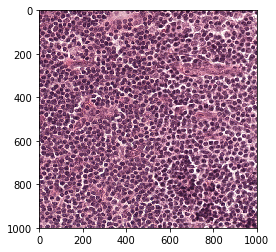

In [9]:
plt.imshow(tumor_rgb)


In [10]:
H_channel = macenko_fit.get_hematoxylin_channel(tumor_rgb)
E_channel = macenko_fit.get_eosin_channel(tumor_rgb)

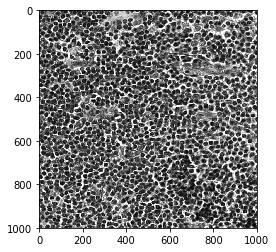

In [11]:
plt.imshow(H_channel, cmap='gray')

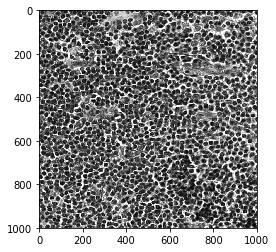

In [12]:
plt.imshow(rgb2gray(H_channel), cmap='gray')

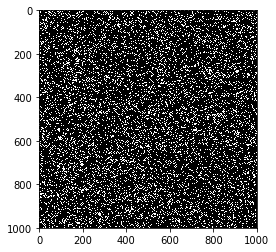

In [15]:
edges = canny(rgb2gray(H_channel), sigma=2,
              low_threshold=0.15, high_threshold=0.8)
plt.imshow(edges, cmap='gray')

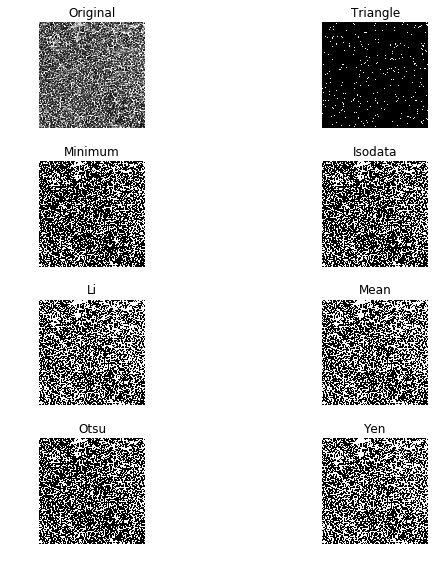

In [16]:
fig, ax = try_all_threshold(rgb2gray(H_channel), figsize=(10, 8), verbose=False)


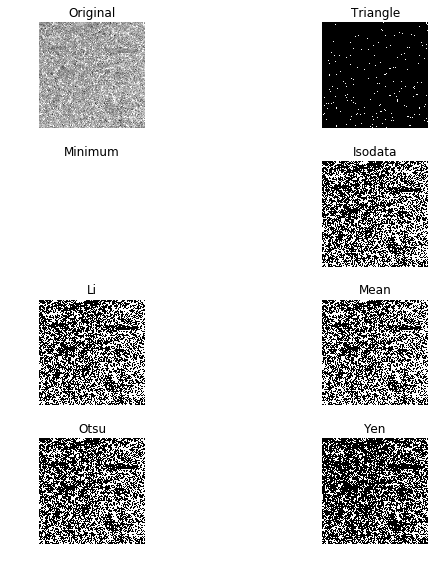

In [17]:
fig, ax = try_all_threshold(rgb2gray(E_channel), figsize=(10, 8), verbose=False)


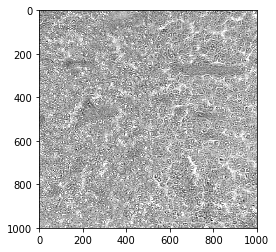

In [18]:
plt.imshow(E_channel, cmap='gray')

Text(0.5,1,'Normalized (Macenko)')

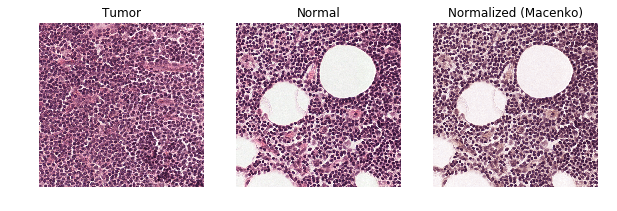

In [19]:
dif = plt.figure(figsize=(10, 10))
ax = plt.subplot(131)
ax.set_axis_off()
ax.imshow(tumor_rgb)
ax.set_title('Tumor')

ax = plt.subplot(132)
ax.set_axis_off()
ax.imshow(normal_rgb)
ax.set_title('Normal')

ax = plt.subplot(133)
ax.set_axis_off()
ax.imshow(normalized_rgb[0])
ax.set_title('Normalized (Macenko)')


